In [2]:
import pyAgrum as gum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
files = os.listdir("outputs/scores")#[::-1]
# np.random.shuffle(files)
len(files)

12979

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz

In [48]:
%%time
df = pd.DataFrame({"items":[],"nodes":[], "timesteps":[], "values":[], "algorithm":[], "scorefunction":[], "fscore":[], "PC1":[], "PC2":[], "PC3":[], "PC4":[]})
for fi, file in enumerate(files[:10]):
    structure, rep = file[9:-4].split("_")
    bn = gum.BayesNet()
    bn.loadBIFXML(f"outputs/structures/structure{structure}_{rep}.bifxml")
    
    for _,row in pd.read_csv(f"outputs/scores/structure{structure}_{rep}.csv").iterrows():
    
        data,_ = gum.generateSample(bn,row["items"],None,False)
        data = data.reindex(sorted(data.columns, key=lambda x: (len(x), int(x.split(".")[1]), x.split(".")[0])), axis=1)
        data = data.astype('int')

        cov = data.cov()

        pca = PCA()
        _ = pca.fit_transform(cov)
        PC_components = np.arange(pca.n_components_) + 1

        ratios = pca.explained_variance_ratio_
        df = pd.concat([df,pd.DataFrame({"items":[row["items"]], "nodes":[row["nodes"]], "timesteps":[row["timesteps"]], "values":[row["values"]], "algorithm":[row["algorithm"]], "scorefunction":[row["score"]], "fscore":[row["fscore"]], "PC1":[ratios[0]], "PC2":[ratios[1]], "PC3":[ratios[2]], "PC4":[ratios[3]]})])

        break
    break
    print(fi)
ratios, PC_components


CPU times: total: 15.6 ms
Wall time: 27.5 ms


(array([5.29151596e-01, 2.70494312e-01, 2.00354092e-01, 1.09903684e-32]),
 array([1, 2, 3, 4]))

In [5]:
%%time
df['algorithmi'] = df['algorithm'].map({'HC': 0, 'TABU':1, '3OFF2':2, 'MIIC':3, 'MMHC':4})
df['scorefunctioni'] = df['scorefunction'].map({'BDEU': 0, 'AIC':1, 'BIC':2, 'K2':3, 'L2L':4})
df

CPU times: total: 0 ns
Wall time: 13.9 ms


,items,nodes,timesteps,values,algorithm,scorefunction,fscore,PC1,PC2,PC3,PC4,algorithmi,scorefunctioni
0,1000.0,4.0,1.0,2.0,HC,BDEU,0.000000,0.508719,0.270377,0.220904,1.836579e-35,0,0
0,2000.0,4.0,1.0,2.0,HC,BDEU,0.800000,0.492648,0.299126,0.208227,3.503167e-34,0,0
0,3000.0,4.0,1.0,2.0,HC,BDEU,0.800000,0.510827,0.281810,0.207363,1.069032e-33,0,0
0,4000.0,4.0,1.0,2.0,HC,BDEU,0.800000,0.508098,0.271857,0.220045,7.928126e-35,0,0
0,5000.0,4.0,1.0,2.0,HC,BDEU,0.800000,0.512683,0.276950,0.210367,3.066877e-34,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,6000.0,4.0,1.0,2.0,HC,BDEU,0.250000,0.571263,0.352698,0.076039,1.852890e-33,0,0
0,7000.0,4.0,1.0,2.0,HC,BDEU,0.285714,0.552996,0.374155,0.072849,4.413549e-33,0,0
0,8000.0,4.0,1.0,2.0,HC,BDEU,0.250000,0.560074,0.369696,0.070230,3.855071e-34,0,0
0,9000.0,4.0,1.0,2.0,HC,BDEU,1.000000,0.558855,0.361081,0.080064,1.350145e-33,0,0


In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [9]:
X = df[["algorithmi","scorefunctioni","PC1","PC2","PC3","PC4"]]
y = df["fscore"]
X

,algorithmi,scorefunctioni,PC1,PC2,PC3,PC4
0,0,0,0.508719,0.270377,0.220904,1.836579e-35
0,0,0,0.492648,0.299126,0.208227,3.503167e-34
0,0,0,0.510827,0.281810,0.207363,1.069032e-33
0,0,0,0.508098,0.271857,0.220045,7.928126e-35
0,0,0,0.512683,0.276950,0.210367,3.066877e-34
...,...,...,...,...,...,...
0,0,0,0.571263,0.352698,0.076039,1.852890e-33
0,0,0,0.552996,0.374155,0.072849,4.413549e-33
0,0,0,0.560074,0.369696,0.070230,3.855071e-34
0,0,0,0.558855,0.361081,0.080064,1.350145e-33


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train

,algorithmi,scorefunctioni,PC1,PC2,PC3,PC4
0,0,0,0.510737,0.399815,0.089448,5.084802e-37
0,0,0,0.476615,0.405013,0.118372,0.000000e+00
0,0,0,0.591308,0.341705,0.066988,2.372841e-34
0,0,0,0.644327,0.278596,0.077077,1.647089e-34
0,0,0,0.507580,0.403279,0.089141,5.731322e-38
...,...,...,...,...,...,...
0,0,0,0.498138,0.290631,0.211232,2.217849e-34
0,0,0,0.622991,0.310183,0.066826,8.799261e-34
0,0,0,0.508382,0.278972,0.212646,2.566120e-34
0,0,0,0.523484,0.387639,0.088877,0.000000e+00


In [9]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
estimators = regr.estimators_
for estimator in estimators:
    export_graphviz(estimator, out_file='tree.dot', 
                feature_names = ["algorithmi","scorefunctioni","PC1","PC2","PC3","PC4"],
                class_names = ["fscore"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
    
    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

    # Display in jupyter notebook
    from IPython.display import Image
    Image(filename = 'tree.png')
    break

In [10]:
y_pred = regr.predict(X_val)
mse = metrics.mean_squared_error(y_val, y_pred)
rmse = mse**0.5
rmse

0.3739210797296845

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
iris.feature_names,iris.target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [25]:
# np.random.choice(files,100)

# FULL RUN

In [7]:
# %%time
# df = pd.DataFrame({"items":[],"nodes":[], "timesteps":[], "values":[], "algorithm":[], "scorefunction":[], "fscore":[], "PC1":[], "PC2":[], "PC3":[], "PC4":[]})
# # for fi, file in enumerate(np.random.choice(files,100)):
# for fi, file in enumerate(files):
#     structure, rep = file[9:-4].split("_")
#     bn = gum.BayesNet()
#     bn.loadBIFXML(f"outputs/structures/structure{structure}_{rep}.bifxml")
    
#     for _,row in pd.read_csv(f"outputs/scores/structure{structure}_{rep}.csv").iterrows():
    
#         data,_ = gum.generateSample(bn,row["items"],None,False)
#         data = data.reindex(sorted(data.columns, key=lambda x: (len(x), int(x.split(".")[1]), x.split(".")[0])), axis=1)
#         data = data.astype('int')

#         cov = data.cov()

#         pca = PCA()
#         _ = pca.fit_transform(cov)
#         PC_components = np.arange(pca.n_components_) + 1

#         ratios = pca.explained_variance_ratio_
#         df = pd.concat([df,pd.DataFrame({"items":[row["items"]], "nodes":[row["nodes"]], "timesteps":[row["timesteps"]], "values":[row["values"]], "algorithm":[row["algorithm"]], "scorefunction":[row["score"]], "fscore":[row["fscore"]], "PC1":[ratios[0]], "PC2":[ratios[1]], "PC3":[ratios[2]], "PC4":[ratios[3]]})])

#     print(fi)
df = pd.read_csv("outputs/pcs.csv")
df

,Unnamed: 0,items,nodes,timesteps,values,algorithm,scorefunction,fscore,PC1,PC2,PC3,PC4,algorithmi,scorefunctioni,fscore_cut,fscorei
0,0,1000.0,4.0,1.0,2.0,HC,BDEU,0.0,0.486077,0.304974,0.208949,2.608415e-34,0,0,"(-0.001, 0.2]",0
1,0,2000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.520111,0.279207,0.200682,5.892113e-33,0,0,"(0.6, 0.8]",4
2,0,3000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.488251,0.293195,0.218554,1.291361e-34,0,0,"(0.6, 0.8]",4
3,0,4000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.521917,0.269725,0.208358,1.046673e-32,0,0,"(0.6, 0.8]",4
4,0,5000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.506709,0.275704,0.217586,5.120065e-33,0,0,"(0.6, 0.8]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129785,0,6000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.234783,0.182627,0.159071,9.934567e-02,2,0,"(0.4, 0.6]",3
129786,0,7000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.243903,0.179655,0.151420,1.009303e-01,2,0,"(0.4, 0.6]",3
129787,0,8000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.232240,0.177127,0.151576,1.032758e-01,2,0,"(0.4, 0.6]",3
129788,0,9000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.240925,0.177770,0.150971,1.058791e-01,2,0,"(0.4, 0.6]",3


pandas._libs.interval.Interval

In [8]:
%%time

def cut(fscore):
    if fscore < 0.2:
        return 0
    elif fscore < 0.4:
        return 1
    elif fscore < 0.6:
        return 2
    elif fscore < 0.8:
        return 3
    return 4

df['algorithmi'] = df['algorithm'].map({'HC': 0, 'TABU':1, '3OFF2':2, 'MIIC':3, 'MMHC':4})
df['scorefunctioni'] = df['scorefunction'].map({'BDEU': 0, 'AIC':1, 'BIC':2, 'K2':3, 'L2L':4})
# df["fscore_cut"] = pd.cut(df["fscore"], [0,0.2,0.4, 0.6, 0.8, 1.0], include_lowest=True)
df['fscorei'] = df['fscore'].apply(cut)
df.to_csv("outputs/pcs.csv")
df

CPU times: total: 1.12 s
Wall time: 1.24 s


,Unnamed: 0,items,nodes,timesteps,values,algorithm,scorefunction,fscore,PC1,PC2,PC3,PC4,algorithmi,scorefunctioni,fscore_cut,fscorei
0,0,1000.0,4.0,1.0,2.0,HC,BDEU,0.0,0.486077,0.304974,0.208949,2.608415e-34,0,0,"(-0.001, 0.2]",0
1,0,2000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.520111,0.279207,0.200682,5.892113e-33,0,0,"(0.6, 0.8]",4
2,0,3000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.488251,0.293195,0.218554,1.291361e-34,0,0,"(0.6, 0.8]",4
3,0,4000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.521917,0.269725,0.208358,1.046673e-32,0,0,"(0.6, 0.8]",4
4,0,5000.0,4.0,1.0,2.0,HC,BDEU,0.8,0.506709,0.275704,0.217586,5.120065e-33,0,0,"(0.6, 0.8]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129785,0,6000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.234783,0.182627,0.159071,9.934567e-02,2,0,"(0.4, 0.6]",3
129786,0,7000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.243903,0.179655,0.151420,1.009303e-01,2,0,"(0.4, 0.6]",3
129787,0,8000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.232240,0.177127,0.151576,1.032758e-01,2,0,"(0.4, 0.6]",3
129788,0,9000.0,6.0,2.0,2.0,3OFF2,BDEU,0.6,0.240925,0.177770,0.150971,1.058791e-01,2,0,"(0.4, 0.6]",3


In [9]:
itemss = df["items"].unique()
nodess = df["nodes"].unique()
timestepss = df["timesteps"].unique()
valuess = df["values"].unique()
algorithms = df["algorithm"].unique()
scorefunctions = df["scorefunction"].unique()
itemss,nodess, timestepss, valuess, algorithms, scorefunctions

(array([ 1000.,  2000.,  3000.,  4000.,  5000.,  6000.,  7000.,  8000.,
         9000., 10000.]),
 array([4., 6., 8.]),
 array([1., 2., 3.]),
 array([2., 4.]),
 array(['HC', 'TABU', 'MMHC', '3OFF2', 'MIIC'], dtype=object),
 array(['BDEU', 'AIC', 'BIC', 'K2', 'L2L'], dtype=object))

In [10]:
%%time
output = pd.DataFrame({"nodes":[], "timesteps":[], "values":[], "algorithm":[], "scorefunction":[], "randomforest":[], "rmse":[]})
# for items in itemss:
#     for nodes in nodess:
#         for timesteps in timestepss:
#             for values in valuess:
#                 for algorithm in algorithms:
#                     for scorefunction in scorefunctions:
#                         sub = df[((df["items"]==items)&(df["nodes"]==nodes)&(df["timesteps"]==timesteps)&(df["values"]==values)&(df["algorithm"]==algorithm)&(df["scorefunction"]==scorefunction))]
#                         X = sub[["algorithmi","scorefunctioni","PC1","PC2","PC3","PC4"]]
#                         y = sub["fscore"]
#                         if len(X) > 1:
#                             X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

#                             regr = RandomForestRegressor()
#                             regr.fit(X_train, y_train)

#                             y_pred = regr.predict(X_val)
#                             mse = metrics.mean_squared_error(y_val, y_pred)
#                             rmse = mse**0.5
#                             output = pd.concat([output,pd.DataFrame({"nodes":[nodes], "timesteps":[timesteps], "values":[values], "algorithm":[algorithm], "scorefunction":[scorefunction], "randomforest":[regr], "rmse":[rmse]})])
                            
#                             print(X.columns, regr.feature_importances_)

X = df[["items","algorithmi","scorefunctioni","PC1","PC2","PC3","PC4"]]
y = df["fscorei"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

regr = RandomForestRegressor()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_val)
mse = metrics.mean_squared_error(y_val, y_pred)
rmse = mse**0.5
# output = pd.concat([output,pd.DataFrame({"nodes":[nodes], "timesteps":[timesteps], "values":[values], "algorithm":[algorithm], "scorefunction":[scorefunction], "randomforest":[regr], "rmse":[rmse]})])

print(rmse, X.columns, regr.feature_importances_)

# output

0.7514445394763181 Index(['items', 'algorithmi', 'scorefunctioni', 'PC1', 'PC2', 'PC3', 'PC4'], dtype='object') [0.08121733 0.1330342  0.04554464 0.21493111 0.19139096 0.19041431
 0.14346744]
CPU times: total: 1min 6s
Wall time: 1min 7s


Text(0, 0.5, 'Mean decrease in impurity')

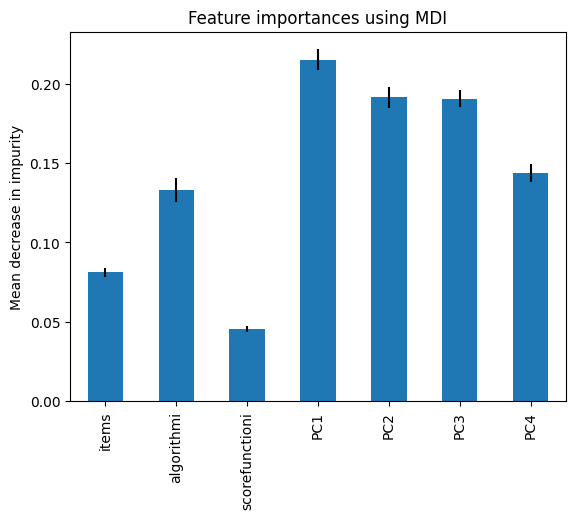

In [11]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics, datasets, ensemble

def print_decision_rules(rf):

    for tree_idx, est in enumerate(rf.estimators_):
        tree = est.tree_
        assert tree.value.shape[1] == 1 # no support for multi-output

        print('TREE: {}'.format(tree_idx))

        iterator = enumerate(zip(tree.children_left, tree.children_right, tree.feature, tree.threshold, tree.value))
        for node_idx, data in iterator:
            left, right, feature, th, value = data

            # left: index of left child (if any)
            # right: index of right child (if any)
            # feature: index of the feature to check
            # th: the threshold to compare against
            # value: values associated with classes            

            # for classifier, value is 0 except the index of the class to return
            class_idx = np.argmax(value[0])

            if left == -1 and right == -1:
                print('{} LEAF: return class={}'.format(node_idx, class_idx))
            else:
                print('{} NODE: if feature[{}] < {} then next={} else next={}'.format(node_idx, feature, th, left, right))    
        break

print_decision_rules(regr)

TREE: 0
0 NODE: if feature[4] < 0.23590828478336334 then next=1 else next=33022
1 NODE: if feature[3] < 0.4796687215566635 then next=2 else next=29755
2 NODE: if feature[0] < 2500.0 then next=3 else next=7620
3 NODE: if feature[1] < 1.5 then next=4 else next=2995
4 NODE: if feature[2] < 3.5 then next=5 else next=2966
5 NODE: if feature[3] < 0.3021254688501358 then next=6 else next=1983
6 NODE: if feature[2] < 2.5 then next=7 else next=1324
7 NODE: if feature[6] < 0.14583682268857956 then next=8 else next=1303
8 NODE: if feature[6] < 0.12075018882751465 then next=9 else next=1164
9 NODE: if feature[5] < 0.17120962589979172 then next=10 else next=1157
10 NODE: if feature[3] < 0.13630184531211853 then next=11 else next=16
11 NODE: if feature[6] < 0.08400161936879158 then next=12 else next=13
12 LEAF: return class=0
13 NODE: if feature[4] < 0.12690892815589905 then next=14 else next=15
14 LEAF: return class=0
15 LEAF: return class=0
16 NODE: if feature[6] < 0.12035773321986198 then next=17

23418 NODE: if feature[4] < 0.19267821311950684 then next=23419 else next=23420
23419 LEAF: return class=0
23420 NODE: if feature[0] < 4500.0 then next=23421 else next=23422
23421 LEAF: return class=0
23422 LEAF: return class=0
23423 NODE: if feature[4] < 0.19946473836898804 then next=23424 else next=23425
23424 LEAF: return class=0
23425 LEAF: return class=0
23426 NODE: if feature[3] < 0.25399263203144073 then next=23427 else next=23428
23427 LEAF: return class=0
23428 NODE: if feature[6] < 0.1354023814201355 then next=23429 else next=23434
23429 NODE: if feature[1] < 0.5 then next=23430 else next=23433
23430 NODE: if feature[3] < 0.25781895220279694 then next=23431 else next=23432
23431 LEAF: return class=0
23432 LEAF: return class=0
23433 LEAF: return class=0
23434 NODE: if feature[0] < 3500.0 then next=23435 else next=23436
23435 LEAF: return class=0
23436 NODE: if feature[4] < 0.20656711608171463 then next=23437 else next=23438
23437 LEAF: return class=0
23438 LEAF: return class=0

In [13]:
# import pickle as pkl
# with open('classify_outputs.pkl', 'wb') as f:
#     pkl.dump([rmse, X.columns, regr.feature_importances_], f)